# Extreme Value Distributions for Groundwater Levels

Fit Generalized Extreme Value (GEV) distribution to annual maximum values.

### 0. Load libraries, data and run previously developed code

> Install dependences if needed (uncomment pip install, if required)

In [2]:
# %pip install --upgrade pandas numpy scipy statsmodels matplotlib datetime
%matplotlib inline

Import necessary libraries (include more if needed).

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import datetime
import wget

### 1. Read and process the data

## Read the dataset

In [4]:
data = pd.read_excel("Example x.3 Groundwater data from Dunshaughlin PW6.xlsx")
# data = pd.read_csv("B40C3303001_meetreeks.csv", sep = ';')
# data_name = wget.download('https://surfdrive.surf.nl/files/index.php/s/2Z1OHYg5Gv9PIAK/download')

datalabel = 'Groundwater level (m aOD)'
data.rename(columns={'Date': 'date', 'Groundwater level (m aOD)': 'level'}, inplace=True)
data.head()

,date,level
0,2008-04-11 01:00:00,101.568
1,2008-04-12 01:00:00,101.542
2,2008-04-13 01:00:00,101.539
3,2008-04-14 01:00:00,101.530
4,2008-04-15 01:00:00,101.511


## Process and plot the timeseries

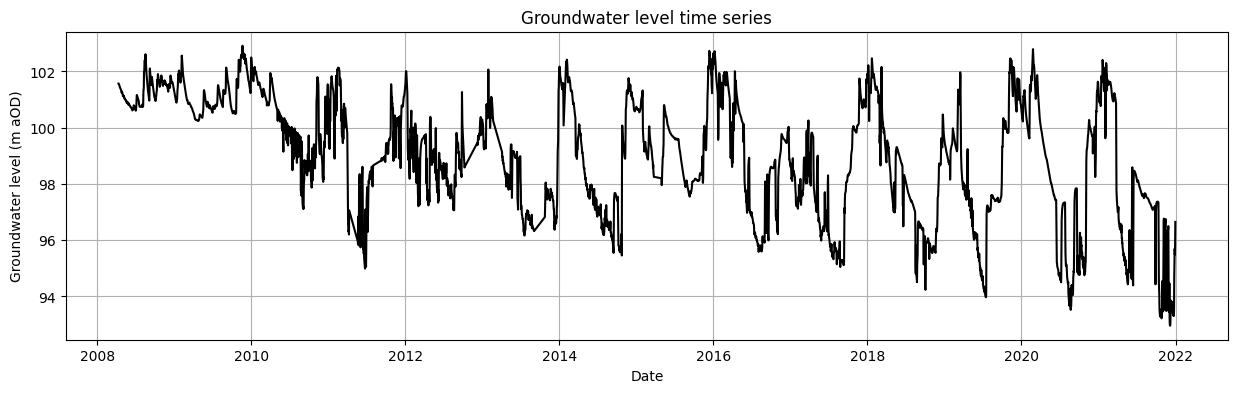

In [5]:
data['date'] = pd.to_datetime(data['date'])
data['level'].dropna

data.set_axis([np.linspace(0, len(data)-1, len(data), dtype=int)], axis='index')
fig, axs=plt.subplots(1, 1)
axs.plot(data['date'], data['level'], 'k', label='Time series')
axs.set_title('Groundwater level time series')
axs.set_xlabel('Date')
axs.set_ylabel(datalabel)
fig.set_size_inches(15, 4)
axs.grid()

## Extract annual maxima

In [6]:
def yearly_maxima(data):
    idx_max = data.groupby(pd.DatetimeIndex(data['date']).year)['level'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

yearly_maxima_list = yearly_maxima(data)
# yearly_maxima_list

**Plot time series including annual maxima** 

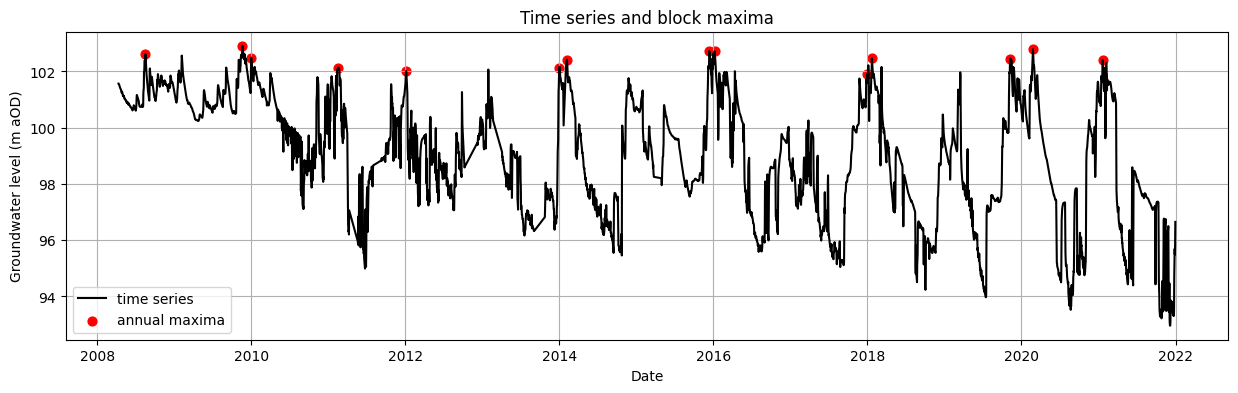

In [7]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['level'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['level'], 40, 'r', label = 'annual maxima')
axs.set_title('Time series and block maxima')
axs.set_xlabel('Date')
axs.set_ylabel(datalabel)
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

### 2. Calculate the empirical distribution function

## Calculate the ECDF

*Steps*:
- Sort the observations of the variable
- Calculate the length (size) of your observations, *n*
- Assign non-exceedance probabilities to each observation, *p=i/(n+1)*, where *i* is the rank
- Store the probabilities and sorted observations in a DataFrame using: 

`ecdf = pd.DataFrame({'F_x':p_data, 'Hs(m)':sorted_data})`

where p_data are the probabilities and sorted_data your sorted observations.

In [8]:
def calculate_ecdf(data):
    sorted_data = np.sort(data) 
    n_data = sorted_data.size 
    p_data = np.arange(1, n_data+1) / (n_data +1)
    ecdf = pd.DataFrame({'F_x':p_data, 'level':sorted_data})
    return ecdf

Apply the ECDF function to the extremes sampled using annual maxima.

In [9]:
ecdf = calculate_ecdf(yearly_maxima_list['level'])
# ecdf.head()

## Plot the ECDF

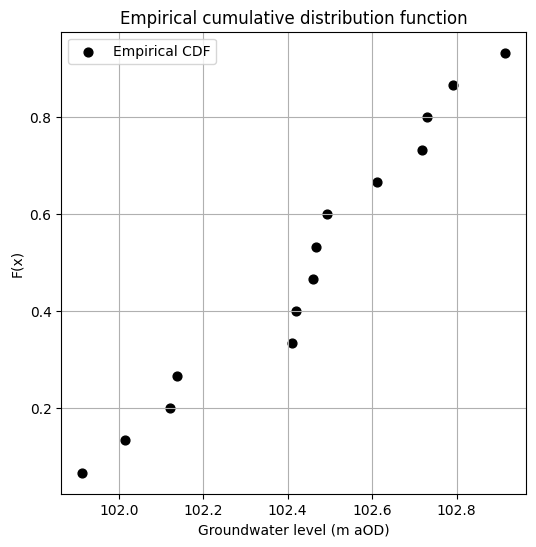

In [10]:
fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['level'], ecdf['F_x'], 40, 'k', label = 'Empirical CDF')
axs.set_title('Empirical cumulative distribution function')
axs.set_ylabel('F(x)')
axs.set_xlabel(datalabel)
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

## 3. Fit extreme value distributions

### Fit Gumbel distribution (for maxima, right-skewed) to the extreme observations obtained with annual maxima

In [11]:
Gumbel_par = stats.gumbel_r.fit(yearly_maxima_list['level'], method = 'mle')
# Print the estimated parameters
print(f"Gumbel location parameter: {Gumbel_par[0]}")
print(f"Gumbel scale parameter: {Gumbel_par[1]}")

Gumbel location parameter: 102.29370489102108
Gumbel scale parameter: 0.28417154982235543


### Fit GEV distribution to the extreme observations obtained with annual maxima

In [12]:
GEV_par = stats.genextreme.fit(yearly_maxima_list['level'], method = 'mle')
# Print the estimated parameters
print(f"GEV shape parameter: {GEV_par[0]}")
print(f"GEV location parameter: {GEV_par[1]}")
print(f"GEV scale parameter: {GEV_par[2]}")

GEV shape parameter: 0.5091529964250412
GEV location parameter: 102.37295889686355
GEV scale parameter: 0.3174345103441154


### Fit Weibull distribution to the extreme observations obtained with annual maxima

In [13]:
Weibull_par = stats.weibull_min.fit(yearly_maxima_list['level'], method = 'mle')
# Print the estimated parameters
print(f"Weibull shape parameter: {Weibull_par[0]}")
print(f"Weibull location parameter: {Weibull_par[1]}")
print(f"Weibull scale parameter: {Weibull_par[2]}")

Weibull shape parameter: 4.864069937181069
Weibull location parameter: 101.23656970495738
Weibull scale parameter: 1.3198460846521454


**Plot the fit**

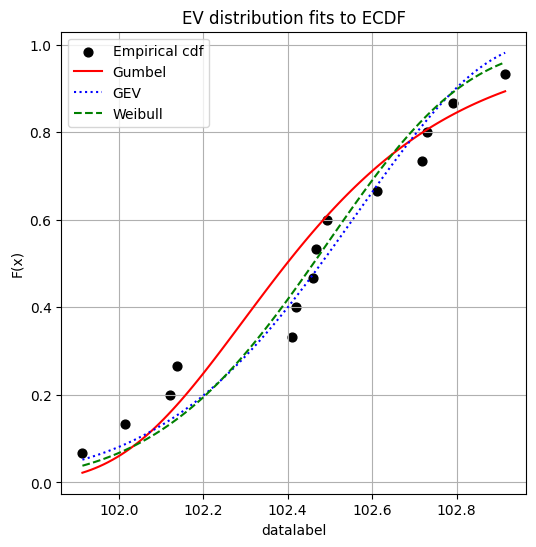

In [14]:
H = np.linspace(min(yearly_maxima_list['level']), max(yearly_maxima_list['level']),100)
Gumbel_p = stats.gumbel_r.cdf(H, Gumbel_par[0], Gumbel_par[1])
GEV_p = stats.genextreme.cdf(H, GEV_par[0], GEV_par[1], GEV_par[2])
Weibull_p = stats.weibull_min.cdf(H, Weibull_par[0], Weibull_par[1], Weibull_par[2])

fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['level'], ecdf['F_x'], 40, 'k', label = 'Empirical cdf')
axs.plot(H, Gumbel_p, 'r', label = 'Gumbel')
axs.plot(H, GEV_p, 'b', linestyle = ':', label = 'GEV')
axs.plot(H, Weibull_p, 'g', linestyle = '--',  label = 'Weibull')
axs.set_title('EV distribution fits to ECDF')
axs.set_ylabel('F(x)')
axs.set_xlabel('datalabel')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

## 4. Statistics & Eurocode values

<figure>
  <IMG SRC="C:\Users\swd\OneDrive - Stichting Deltares\Scripts and code\Extreme Value Analysis (Jupyter)\Tabel_EN_water_values.png" WIDTH=300 ALIGN="left">
</figure>

### Distribution-independent values

In [25]:
GW_perma = data['level'].quantile(.5)  # CAREFUL, ONLY FOR EVENLY SPACED REASINGS IN TIME 
print('Quasi-permanent (fraction of time exceeded = 50%) ', GW_perma) 
GW_freq = data['level'].quantile(.99)  # CAREFUL, ONLY FOR EVENLY SPACED REASINGS IN TIME
print('Frequent (fraction of time exceeded = 1%) ', GW_freq)   

Quasi-permanent (fraction of time exceeded = 50%)  99.176
Frequent (fraction of time exceeded = 1%)  102.431


### 4.1 Gumbel fit

In [26]:
GW_comb_T10_Gumbel = stats.gumbel_r.ppf(1-1/10, Gumbel_par[0], Gumbel_par[1])
print('Comnination (return period 10 years) ', GW_comb_T10_Gumbel)
GW_char_T50_Gumbel = stats.gumbel_r.ppf(1-1/50, Gumbel_par[0], Gumbel_par[1])
print('Characteristic (return period 50 years) ', GW_char_T50_Gumbel)
GW_acc_T1000_Gumbel = stats.gumbel_r.ppf(1-1/1000, Gumbel_par[0], Gumbel_par[1])
print('Accidental (return period 1000 years) ', GW_acc_T1000_Gumbel)

Comnination (return period 10 years)  102.93319526209305
Characteristic (return period 50 years)  103.40252484675847
Accidental (return period 1000 years)  104.25655026943012


#### Plot Eurocode values (Gumbel)

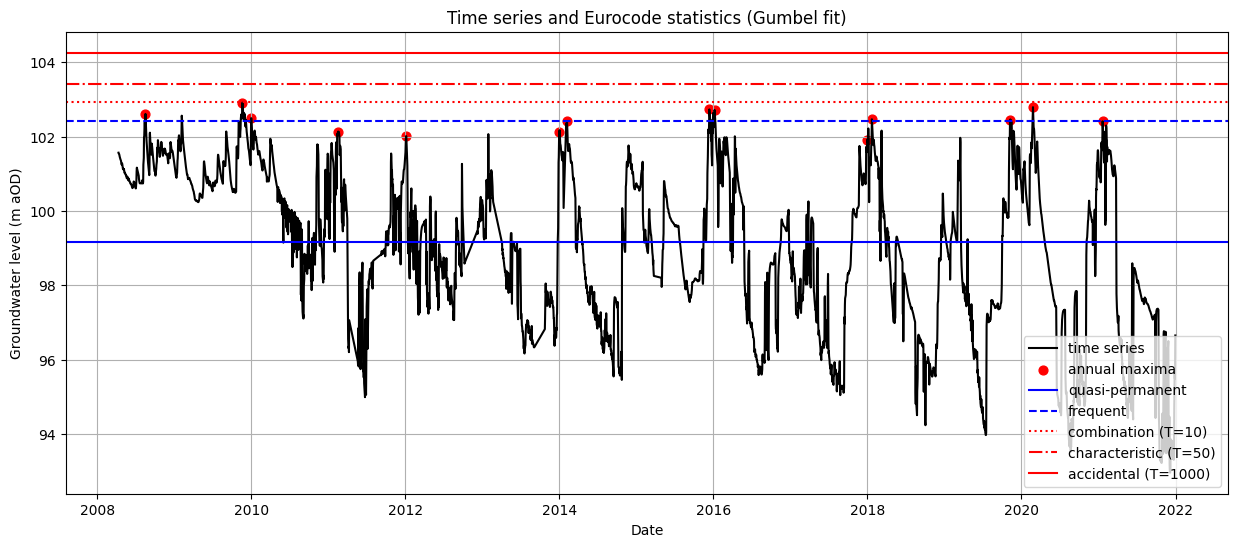

In [33]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['level'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['level'], 40, 'r', label = 'annual maxima')
axs.axhline(y = GW_perma, color = 'b', linestyle = '-', label = 'quasi-permanent')
axs.axhline(y = GW_freq, color = 'b', linestyle = '--', label = 'frequent')
axs.axhline(y = GW_comb_T10_Gumbel, color = 'r', linestyle = ':', label = 'combination (T=10)')
axs.axhline(y = GW_char_T50_Gumbel, color = 'r', linestyle = '-.', label = 'characteristic (T=50)')
axs.axhline(y = GW_acc_T1000_Gumbel, color = 'r', linestyle = '-', label = 'accidental (T=1000)')
axs.set_title('Time series and Eurocode statistics (Gumbel fit)')
axs.set_xlabel('Date')
axs.set_ylabel(datalabel)
fig.set_size_inches(15, 6)
axs.grid()
axs.legend(loc='lower right')

### 4.2 GEV fit

In [34]:
GW_comb_T10_GEV = stats.genextreme.ppf(1-1/10, GEV_par[0], GEV_par[1], GEV_par[2])
print('Comnination (return period 10 years) ', GW_comb_T10_GEV)
GW_char_T50_GEV = stats.genextreme.ppf(1-1/50, GEV_par[0], GEV_par[1], GEV_par[2])
print('Characteristic (return period 50 years) ', GW_char_T50_GEV)
GW_acc_T1000_GEV = stats.genextreme.ppf(1-1/1000, GEV_par[0], GEV_par[1], GEV_par[2])
print('Accidental (return period 1000 years) ', GW_acc_T1000_GEV)

Comnination (return period 10 years)  102.79817125440739
Characteristic (return period 50 years)  102.91090825622709
Accidental (return period 1000 years)  102.97790276047091


#### Plot Eurcocode values (GEV)

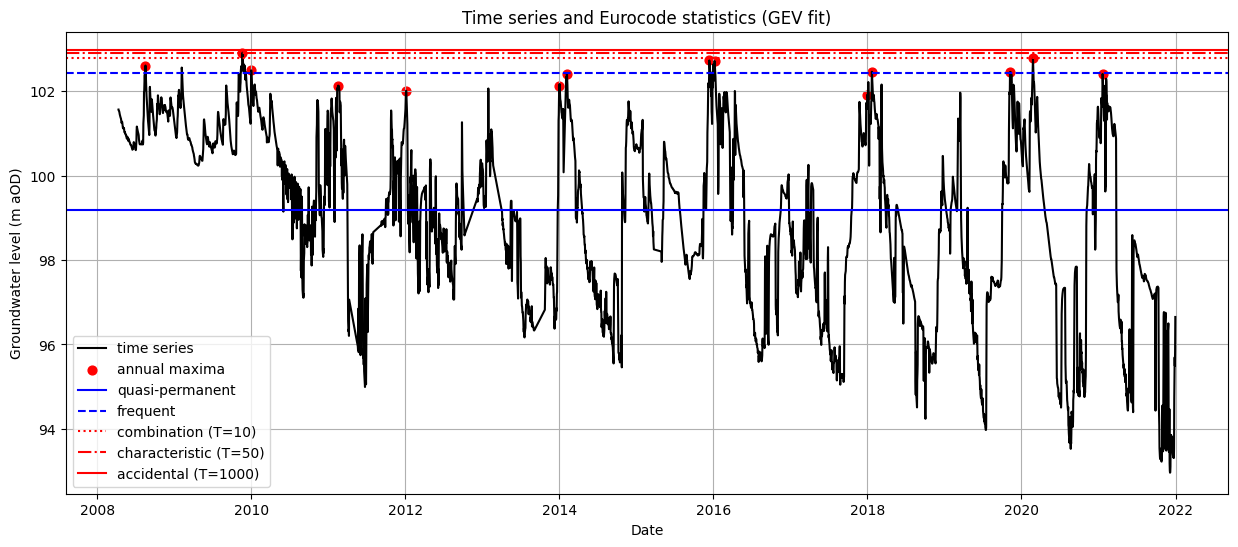

In [35]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['level'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['level'], 40, 'r', label = 'annual maxima')
axs.axhline(y = GW_perma, color = 'b', linestyle = '-', label = 'quasi-permanent')
axs.axhline(y = GW_freq, color = 'b', linestyle = '--', label = 'frequent')
axs.axhline(y = GW_comb_T10_GEV, color = 'r', linestyle = ':', label = 'combination (T=10)')
axs.axhline(y = GW_char_T50_GEV, color = 'r', linestyle = '-.', label = 'characteristic (T=50)')
axs.axhline(y = GW_acc_T1000_GEV, color = 'r', linestyle = '-', label = 'accidental (T=1000)')
axs.set_title('Time series and Eurocode statistics (GEV fit)')
axs.set_xlabel('Date')
axs.set_ylabel(datalabel)
fig.set_size_inches(15, 6)
axs.grid()
axs.legend()

### 4.3 Weibull fit

In [36]:
GW_comb_T10_Weibull = stats.weibull_min.ppf(1-1/10, Weibull_par[0], Weibull_par[1], Weibull_par[2])
print('Comnination (return period 10 years) ', GW_comb_T10_Weibull)
GW_char_T50_Weibull = stats.weibull_min.ppf(1-1/50, Weibull_par[0], Weibull_par[1], Weibull_par[2])
print('Characteristic (return period 50 years) ', GW_char_T50_Weibull)
GW_acc_T1000_Weibull = stats.weibull_min.ppf(1-1/1000, Weibull_par[0], Weibull_par[1], Weibull_par[2])
print('Accidental (return period 1000 years) ', GW_acc_T1000_Weibull)

Comnination (return period 10 years)  102.80328795972564
Characteristic (return period 50 years)  102.98365693054673
Accidental (return period 1000 years)  103.20030007386649


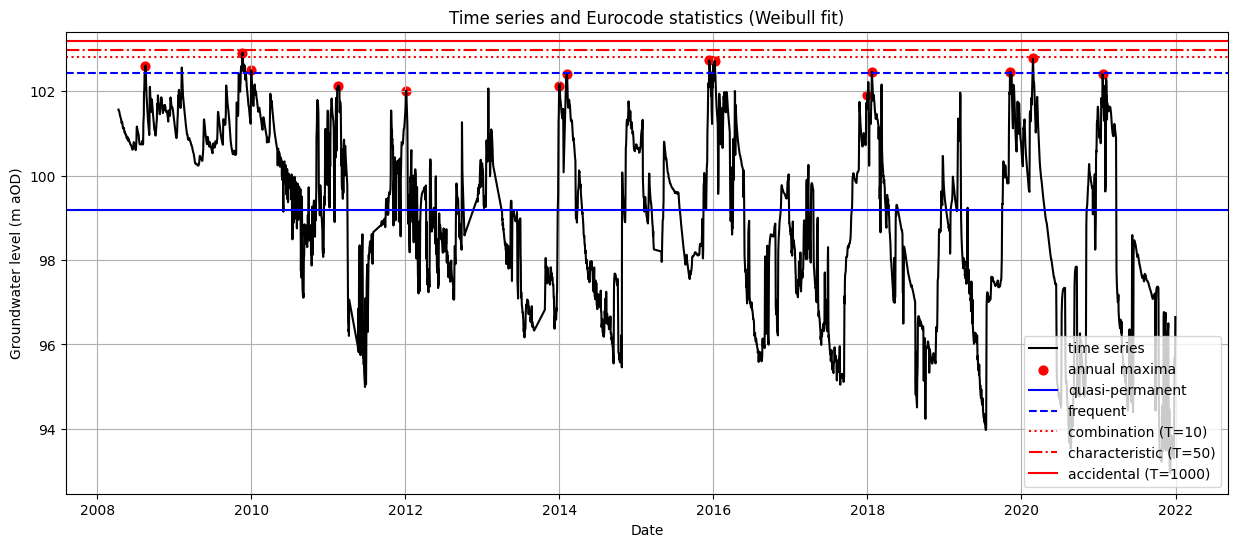

In [37]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['level'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['level'], 40, 'r', label = 'annual maxima')
axs.axhline(y = GW_perma, color = 'b', linestyle = '-', label = 'quasi-permanent')
axs.axhline(y = GW_freq, color = 'b', linestyle = '--', label = 'frequent')
axs.axhline(y = GW_comb_T10_Weibull, color = 'r', linestyle = ':', label = 'combination (T=10)')
axs.axhline(y = GW_char_T50_Weibull, color = 'r', linestyle = '-.', label = 'characteristic (T=50)')
axs.axhline(y = GW_acc_T1000_Weibull, color = 'r', linestyle = '-', label = 'accidental (T=1000)')
axs.set_title('Time series and Eurocode statistics (Weibull fit)')
axs.set_xlabel('Date')
axs.set_ylabel(datalabel)
fig.set_size_inches(15, 6)
axs.grid()
axs.legend(loc='lower right')

#### Plot PDF comparison

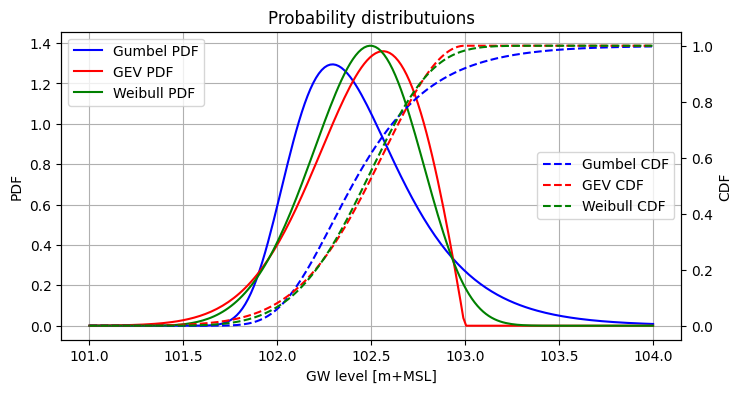

In [38]:
x = np.linspace(101, 104, 200)
fig, axs1 = plt.subplots(1, 1)
axs1.plot(x, stats.gumbel_r.pdf(x, Gumbel_par[0], Gumbel_par[1]), 'b', linestyle = '-', label='Gumbel PDF')
axs1.plot(x, stats.genextreme.pdf(x, GEV_par[0], GEV_par[1], GEV_par[2]), 'r', linestyle = '-', label='GEV PDF')
axs1.plot(x, stats.weibull_min.pdf(x, Weibull_par[0], Weibull_par[1], Weibull_par[2]), 'g', linestyle = '-', label='Weibull PDF')
axs2 = axs1.twinx()
axs2.plot(x, stats.gumbel_r.cdf(x, Gumbel_par[0], Gumbel_par[1]), 'b', linestyle = '--', label='Gumbel CDF')
axs2.plot(x, stats.genextreme.cdf(x, GEV_par[0], GEV_par[1], GEV_par[2]), 'r', linestyle = '--', label='GEV CDF')
axs2.plot(x, stats.weibull_min.cdf(x, Weibull_par[0], Weibull_par[1], Weibull_par[2]), 'g', linestyle = '--', label='Weibull CDF')
axs1.set_title('Probability distributuions')
axs1.set_xlabel('GW level [m+MSL]')
axs1.set_ylabel('PDF')
axs2.set_ylabel('CDF')
fig.set_size_inches(8, 4)
axs1.grid()
axs1.legend(loc='upper left')
axs2.legend(loc='center right')